## Correlation Analysis

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt
import seaborn as sns

# loading the data
data_forecast = pd.read_csv("ForecastData.csv", index_col=0)
# Date to datetime
data_forecast.index = pd.to_datetime(data_forecast.index)

# load csv ProcessedData_2025.csv
data_forecast_2025 = pd.read_csv("ProcessedData.csv", index_col=0)
data_forecast_2025.index = pd.to_datetime(data_forecast_2025.index)
# for now we will only use VIX Close, WTI Spot Price, IT Adj Close_Return, HC Adj Close_Return AND CD Adj Close_Return, IT Volume, HD Volume, CD Volume
data_forecast_2025 = data_forecast_2025[['VIX Close', 'WTI Log Daily Change', 'IT_Log_Return', 'HC_Log_Return', 'CD_Log_Return', 'IT Volume', 'HC Volume', 'CD Volume']]
# rename VIX Close to VIX, IT Adj Close_Return to IT Daily Return, HC Adj Close_Return to HC Daily Return, CD Adj Close_Return to CD Daily Return
data_forecast_2025.rename(columns={'VIX Close': 'VIX'})#, 'IT_Return': 'IT Daily Return', 'HC Adj Close_Return': 'HC Daily Return', 'CD Adj Close_Return': 'CD Daily Return'}, inplace=True)
# remame HC Daily Return to Health Care Daily Return, CD Daaily Return to Consumer Discretionary Daily Return, IT Daily Return to Information Technology Daily Return
data_forecast_2025.rename(columns={'HC_Log_Return': 'Health Care Daily Log Return', 'CD_Log_Return': 'Consumer Discretionary Daily Log Return', 'IT_Log_Return': 'Information Technology Daily Log Return'}, inplace=True)
data_forecast_2025.head()

# Define sectors
sectors = ['Health Care Daily Log Return', 'Information Technology Daily Log Return', 'Consumer Discretionary Daily Log Return']
# join the two to get the full data, but ensure no dates are duplicated
data_forecast = pd.concat([data_forecast, data_forecast_2025])
data_forecast = data_forecast.loc[~data_forecast.index.duplicated(keep='first')]
#data_forecast = data_forecast.dropna()

In [24]:
data_forecast

,VIX Close,WTI Log Daily Change,Information Technology Daily Log Return,Health Care Daily Log Return,Consumer Discretionary Daily Log Return,IT Volume,HC Volume,CD Volume,Uncertainty Regime
Date,,,,,,,,,
1993-05-05,12.38,0.002937,0.008621,0.008757,-0.002610,0,0,0,Normal Uncertainty
1993-05-06,13.22,0.001465,-0.006131,-0.013274,-0.003120,0,0,0,Normal Uncertainty
1993-05-07,13.01,-0.002933,0.008729,-0.004760,-0.000605,0,0,0,Normal Uncertainty
1993-05-10,13.72,-0.000490,-0.000779,0.001220,0.005332,0,0,0,Normal Uncertainty
1993-05-11,13.35,-0.001961,-0.006381,0.002877,0.002706,0,0,0,Normal Uncertainty
...,...,...,...,...,...,...,...,...,...
2025-04-22,30.57,0.017490,0.024226,0.017848,0.031825,806867100,223050800,472384400,NaN
2025-04-23,28.45,-0.030810,0.028758,0.005340,0.027267,978415600,280000500,591385400,NaN
2025-04-24,26.47,0.014423,0.034781,0.012289,0.022318,938353200,254195200,431896300,NaN


In [25]:
window = 20

def rolling_corr(series1, series2, method='pearson'):
    return series1.rolling(window).corr(series2) if method == 'pearson' else \
           series1.rolling(window).apply(lambda x: x.rank().corr(series2[x.index].rank()), raw=False)

# Apply for each sector and method
for sector in ['Health Care', 'Information Technology', 'Consumer Discretionary']:
    ret_col = f'{sector} Daily Log Return'
    
    # Pearson
    data_forecast[f'VIX Corr {sector} Pearson'] = data_forecast['VIX Close'].rolling(window).corr(data_forecast[ret_col])
    data_forecast[f'WTI Corr {sector} Pearson'] = data_forecast['WTI Log Daily Change'].rolling(window).corr(data_forecast[ret_col])
    
    # Spearman (rank correlation)
    data_forecast[f'VIX Corr {sector} Spearman'] = data_forecast[ret_col].rolling(window).apply(
        lambda x: x.rank().corr(data_forecast['VIX Close'][x.index].rank()), raw=False)
    
    data_forecast[f'WTI Corr {sector} Spearman'] = data_forecast[ret_col].rolling(window).apply(
        lambda x: x.rank().corr(data_forecast['WTI Log Daily Change'][x.index].rank()), raw=False)


In [26]:
import statsmodels.api as sm

def rolling_r2(df, y_col, x_cols, window):
    r2_series = []

    for i in range(len(df)):
        if i < window:
            r2_series.append(np.nan)
            continue
        y = df[y_col].iloc[i-window:i]
        X = df[x_cols].iloc[i-window:i]
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        r2_series.append(model.rsquared)

    return pd.Series(r2_series, index=df.index)

# Apply to each sector
for sector in ['Health Care', 'Information Technology', 'Consumer Discretionary']:
    ret_col = f'{sector} Daily Log Return'
    data_forecast[f'Joint R² {sector}'] = rolling_r2(data_forecast, ret_col, ['VIX Close', 'WTI Log Daily Change'], window)


In [27]:
smoothing_window = 5 # For smoothing the lines

for col in data_forecast.columns:
    if 'Corr' in col or 'Joint R²' in col:
        data_forecast[f'{col} Smoothed'] = data_forecast[col].rolling(smoothing_window).mean()


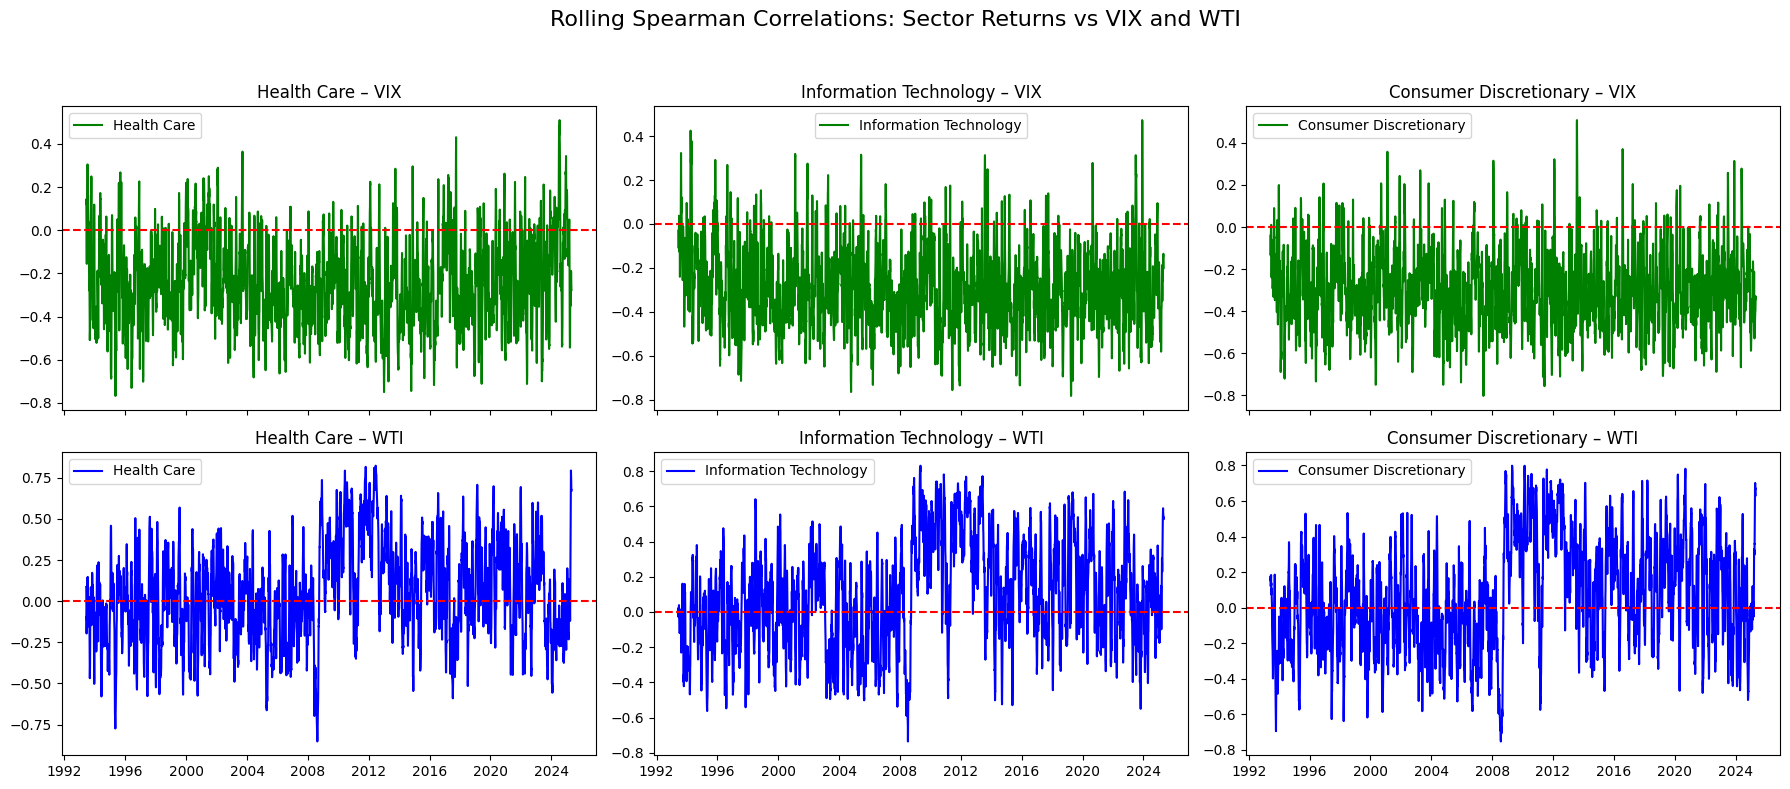

In [28]:
def plot_spearman_grid(data, sectors):
    fig, axs = plt.subplots(2, 3, figsize=(18, 8), sharex=True)

    drivers = ['VIX', 'WTI']
    colors = ['green', 'blue']

    for i, sector in enumerate(sectors):
        for j, driver in enumerate(drivers):
            row = j  # VIX in row 0, WTI in row 1
            col = i  # one column per sector
            col_name = f'{driver} Corr {sector} Spearman Smoothed'

            axs[row, col].plot(data.index, data[col_name], color=colors[j], label=f'{sector}')
            axs[row, col].axhline(0, color='red', linestyle='--', linewidth=1.5)
            axs[row, col].set_title(f'{sector} – {driver}')
            axs[row, col].grid(False)
            axs[row, col].legend()

    fig.suptitle('Rolling Spearman Correlations: Sector Returns vs VIX and WTI', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

sectors = ['Health Care', 'Information Technology', 'Consumer Discretionary']
plot_spearman_grid(data_forecast, sectors)


In [29]:
# combining the average rolling correlations for each sector and their volatility
correlation_table = pd.DataFrame(index=sectors, columns=['VIX', 'WTI'])

for sector in sectors:
    # Calculate average rolling correlations
    vix_avg = data_forecast[f'VIX Corr {sector} Spearman Smoothed'].mean()
    wti_avg = data_forecast[f'WTI Corr {sector} Spearman Smoothed'].mean()
    correlation_table.loc[sector, 'VIX'] = vix_avg
    correlation_table.loc[sector, 'WTI'] = wti_avg
    # Calculate volatility (standard deviation of rolling correlations)
    vix_vol = data_forecast[f'VIX Corr {sector} Spearman Smoothed'].std()
    wti_vol = data_forecast[f'WTI Corr {sector} Spearman Smoothed'].std()
    correlation_table.loc[sector, 'VIX Volatility'] = vix_vol
    correlation_table.loc[sector, 'WTI Volatility'] = wti_vol
    

In [30]:
correlation_table

,VIX,WTI,VIX Volatility,WTI Volatility
Health Care,-0.239921,0.043874,0.197493,0.288066
Information Technology,-0.291214,0.092305,0.183113,0.291843
Consumer Discretionary,-0.29592,0.070757,0.180148,0.301821


In [31]:
# make one for pre and post 2009
pre_2009 = data_forecast[data_forecast.index < '2008-01-01']
post_2009 = data_forecast[data_forecast.index >= '2008-01-01']

# Pre-2009
correlation_table_pre = pd.DataFrame(index=sectors, columns=['VIX', 'WTI'])

for sector in sectors:
    # Calculate average rolling correlations
    vix_avg = pre_2009[f'VIX Corr {sector} Spearman Smoothed'].mean()
    wti_avg = pre_2009[f'WTI Corr {sector} Spearman Smoothed'].mean()
    correlation_table_pre.loc[sector, 'VIX'] = vix_avg
    correlation_table_pre.loc[sector, 'WTI'] = wti_avg
    # Calculate volatility (standard deviation of rolling correlations)
    vix_vol = pre_2009[f'VIX Corr {sector} Spearman Smoothed'].std()
    wti_vol = pre_2009[f'WTI Corr {sector} Spearman Smoothed'].std()
    correlation_table_pre.loc[sector, 'VIX Volatility'] = vix_vol
    correlation_table_pre.loc[sector, 'WTI Volatility'] = wti_vol

correlation_table_pre


,VIX,WTI,VIX Volatility,WTI Volatility
Health Care,-0.230316,-0.058688,0.191836,0.230359
Information Technology,-0.276121,-0.037765,0.186596,0.229102
Consumer Discretionary,-0.291028,-0.06744,0.179173,0.233165


In [32]:
# post 2009
correlation_table_post = pd.DataFrame(index=sectors, columns=['VIX', 'WTI'])

for sector in sectors:
    # Calculate average rolling correlations
    vix_avg = post_2009[f'VIX Corr {sector} Spearman Smoothed'].mean()
    wti_avg = post_2009[f'WTI Corr {sector} Spearman Smoothed'].mean()
    correlation_table_post.loc[sector, 'VIX'] = vix_avg
    correlation_table_post.loc[sector, 'WTI'] = wti_avg
    # Calculate volatility (standard deviation of rolling correlations)

    vix_vol = post_2009[f'VIX Corr {sector} Spearman Smoothed'].std()
    wti_vol = post_2009[f'WTI Corr {sector} Spearman Smoothed'].std()
    correlation_table_post.loc[sector, 'VIX Volatility'] = vix_vol
    correlation_table_post.loc[sector, 'WTI Volatility'] = wti_vol

correlation_table_post

,VIX,WTI,VIX Volatility,WTI Volatility
Health Care,-0.247988,0.130016,0.201790,0.303097
Information Technology,-0.30389,0.201551,0.179178,0.294095
Consumer Discretionary,-0.300029,0.186829,0.180881,0.304047


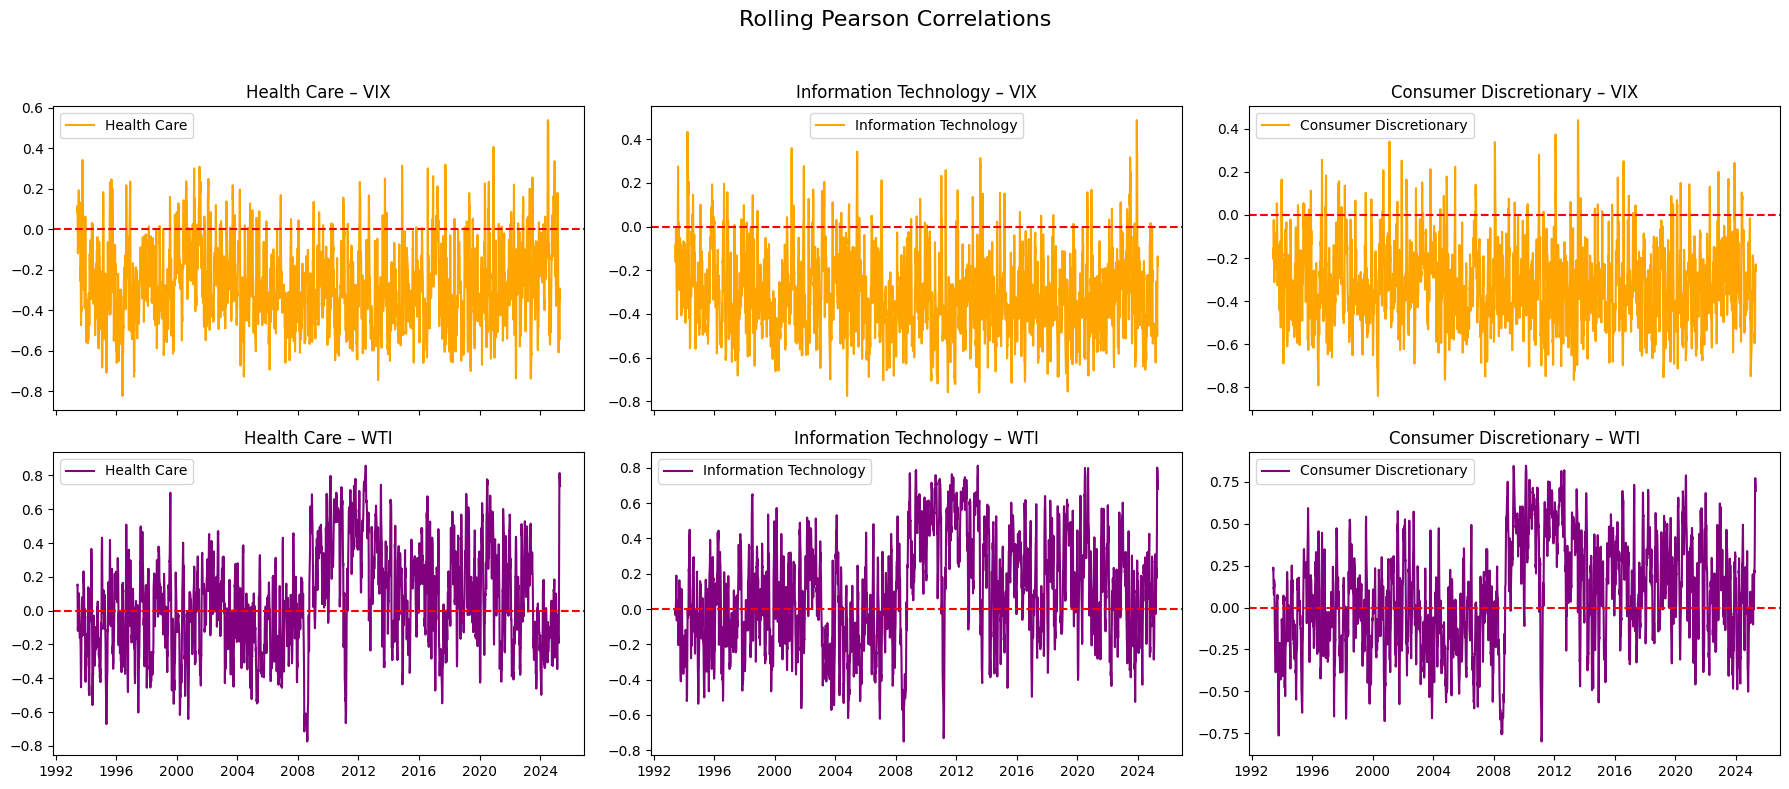

In [33]:
def plot_pearson_grid(data, sectors):
    fig, axs = plt.subplots(2, 3, figsize=(18, 8), sharex=True)

    drivers = ['VIX', 'WTI']
    colors = ['orange', 'purple']

    for i, sector in enumerate(sectors):
        for j, driver in enumerate(drivers):
            row = j
            col = i
            col_name = f'{driver} Corr {sector} Pearson Smoothed'

            axs[row, col].plot(data.index, data[col_name], color=colors[j], label=f'{sector}')
            axs[row, col].axhline(0, color='red', linestyle='--', linewidth=1.5)
            axs[row, col].set_title(f'{sector} – {driver}')
            axs[row, col].grid(False)
            axs[row, col].legend()

    fig.suptitle('Rolling Pearson Correlations', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_pearson_grid(data_forecast, sectors)


In [34]:
from scipy.stats import mannwhitneyu
import pandas as pd

def mann_whitney_test(series1, series2):
    # Drop NaNs and align sizes
    x = series1.dropna().abs()
    y = series2.dropna().abs()
    min_len = min(len(x), len(y))
    x, y = x[-min_len:], y[-min_len:]
    stat, p_value = mannwhitneyu(x, y, alternative='two-sided')
    return round(stat, 2), round(p_value, 4)

# === PART 1: Cross-Sector Comparisons ===
def sector_comparison(data, sectors, drivers, method='Spearman'):
    results = []
    for driver in drivers:
        for i in range(len(sectors)):
            for j in range(i+1, len(sectors)):
                col1 = f'{driver} Corr {sectors[i]} {method} Smoothed'
                col2 = f'{driver} Corr {sectors[j]} {method} Smoothed'
                stat, p = mann_whitney_test(data[col1], data[col2])
                results.append({
                    'Driver': driver,
                    'Sector 1': sectors[i],
                    'Sector 2': sectors[j],
                    'Statistic': stat,
                    'p-value': p
                })
    return pd.DataFrame(results)

# === PART 2: Pre vs Post GFC for Each Sector ===
def pre_post_gfc_comparison(data, sectors, drivers, split_date='2008-01-01', method='Spearman'):
    results = []
    pre_data = data[data.index < split_date]
    post_data = data[data.index >= split_date]

    for sector in sectors:
        for driver in drivers:
            col = f'{driver} Corr {sector} {method} Smoothed'
            stat, p = mann_whitney_test(pre_data[col], post_data[col])
            results.append({
                'Sector': sector,
                'Driver': driver,
                'Statistic': stat,
                'p-value': p
            })
    return pd.DataFrame(results)

# === Run the tests ===
sectors = ['Health Care', 'Information Technology', 'Consumer Discretionary']
drivers = ['VIX', 'WTI']

cross_sector_df = sector_comparison(data_forecast, sectors, drivers)
pre_post_df = pre_post_gfc_comparison(data_forecast, sectors, drivers)

# Display outputs
print("Cross-Sector Correlation Comparison:")
print(cross_sector_df.to_string(index=False))

print("\nPre vs Post-GFC Correlation Comparison:")
print(pre_post_df.to_string(index=False))


Cross-Sector Correlation Comparison:
Driver               Sector 1               Sector 2  Statistic  p-value
   VIX            Health Care Information Technology 27402013.5   0.0000
   VIX            Health Care Consumer Discretionary 27199057.0   0.0000
   VIX Information Technology Consumer Discretionary 31684792.0   0.4684
   WTI            Health Care Information Technology 30251919.5   0.0000
   WTI            Health Care Consumer Discretionary 29602870.0   0.0000
   WTI Information Technology Consumer Discretionary 31269467.5   0.0315

Pre vs Post-GFC Correlation Comparison:
                Sector Driver  Statistic  p-value
           Health Care    VIX  6349508.5   0.0009
           Health Care    WTI  5303100.0   0.0000
Information Technology    VIX  6165525.0   0.0000
Information Technology    WTI  5095390.5   0.0000
Consumer Discretionary    VIX  6250011.0   0.0000
Consumer Discretionary    WTI  4973870.0   0.0000
